In [3]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os

## Dataset Setup

In [4]:
final_df = pd.read_parquet("../dataset/combined.parquet")
final_df = final_df.dropna(axis=0)

In [5]:
final_df = final_df[["audio_filepath", "duration" ,"text"]]
final_df = final_df[final_df["duration"] > 2]
final_df.head(3)
len(final_df)

4872

## Characters and Preprocessing

In [6]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz' "]

char_to_idx = {char: idx for idx, char in enumerate(characters)}
idx_to_char = {idx: char for char, idx in char_to_idx.items()}

#OOV token handling
oov_token = len(characters)  # next index for out-of-vocabulary
char_to_idx_default = lambda c: char_to_idx.get(c, oov_token)

#string to indices
def text_to_indices(text):
    return torch.tensor([char_to_idx_default(c) for c in text], dtype=torch.long)

#Convert indices back to text
def indices_to_text(indices):
    return ''.join([idx_to_char.get(idx.item(), '') for idx in indices])

In [7]:
input_text = "shivansh"
encoded = text_to_indices(input_text)
print("Encoded:", encoded)

decoded = indices_to_text(encoded)
print("Decoded:", decoded)

Encoded: tensor([18,  7,  8, 21,  0, 13, 18,  7])
Decoded: shivansh


## Pre-Processing

In [46]:
import torchaudio
from IPython.display import Audio

import re
import random
import io

In [15]:
def plot_waveform(wav, sample_rate):
        num_channels, num_frames = wav.shape
        time_axis = torch.arange(0, num_frames) / sample_rate

        figure, axes = plt.subplots(num_channels, 1)
        if num_channels == 1:
            axes = [axes]
        for c in range(num_channels):
            axes[c].plot(time_axis, wav[c], linewidth=1)
            axes[c].grid(True)
            if num_channels > 1:
                axes[c].set_ylabel(f"Channel {c+1}")
        figure.suptitle("Testing Waveform")

In [31]:
def load_audio(i): # tuple of wav as tensor and sample rate and label as encoded tensor from parquet file.values
    audio_bytes = i["audio_filepath"]["bytes"]
    lbl = text_to_indices(i["text"])
    wav, sr = torchaudio.load(io.BytesIO(audio_bytes))
    return [wav, sr, lbl]

In [38]:
# values array
aud_ar = [load_audio(r) for i, r in final_df.iterrows()]
    

Sample rate: 16000
Waveform shape: torch.Size([1, 151340])
Label Encoded:  tensor([18, 14, 12,  4, 27,  8, 13, 27, 19,  7,  4, 27, 18, 19,  0, 17, 19,  8,
        13,  6, 28, 27, 19,  7,  4, 13, 27,  0,  6,  0,  8, 13, 27, 28, 27, 15,
        14, 20, 17,  4,  3, 27,  0, 13,  3, 27,  5,  8, 13,  0, 11, 11, 24, 27,
         8, 19, 27,  7,  0, 15, 15,  4, 13,  4,  3, 27, 19,  7,  0, 19, 27,  8,
        19, 27,  1,  4,  2,  0, 12,  4, 27, 18, 14, 27, 22,  4, 19, 27, 19,  7,
         0, 19, 27, 19, 14, 27,  7,  0, 21,  4, 27,  0])
Label Decoded:  some in the starting then again  poured and finally it happened that it became so wet that to have a


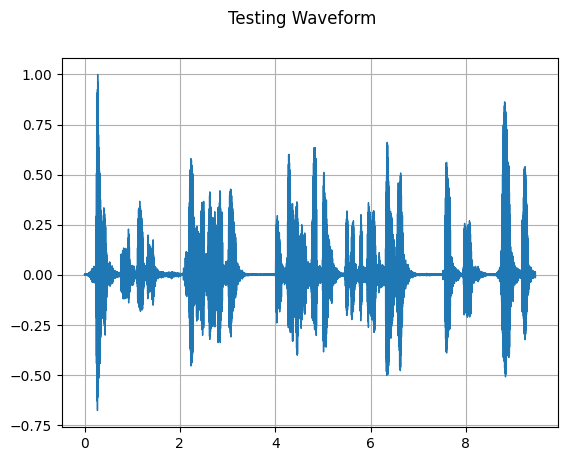

In [43]:
print("Sample rate:", aud_ar[0][1])
print("Waveform shape:", aud_ar[0][0].shape)
print("Label Encoded: ", aud_ar[0][2])
print("Label Decoded: ", indices_to_text(aud_ar[0][2]))

plot_waveform(aud_ar[0][0], aud_ar[0][1])

In [47]:
Audio(aud_ar[0][0].numpy()[0], rate=aud_ar[0][1])

# Main Preprocessing Logic

In [9]:
# An integer scalar Tensor. The window length in samples.
frame_length = 256
# An integer scalar Tensor. The number of samples to step.
frame_step = 160
# An integer scalar Tensor. The size of the FFT to apply.
# If not provided, uses the smallest power of 2 enclosing frame_length.
fft_length = 384

In [59]:
def add_noise(wav, noise_factor=0.005):
    noise = torch.randn(wav.size()) * noise_factor
    augmented_wav = wav + noise
    return augmented_wav.clamp(0, 1)

def pitch_shift(wav, n_steps=2):
    # Shift the pitch of the audio signal
    return torchaudio.functional.pitch_shift(wav, 16000, n_steps=n_steps)

def time_stretch(wav, rate=1.2, n_fft=1024, hop_length=256):
    # Create spectrogram and inverse transforms
    spectrogram = torchaudio.transforms.Spectrogram(n_fft=n_fft, hop_length=hop_length, power=None)
    inverse_spectrogram = torchaudio.transforms.InverseSpectrogram(n_fft=n_fft, hop_length=hop_length)
    
    # Convert waveform to complex spectrogram
    spec = spectrogram(wav)

    # Apply time stretch (requires complex spectrogram input)
    time_stretch = torchaudio.transforms.TimeStretch(hop_length=hop_length, n_freq=n_fft // 2 + 1)
    stretched_spec = time_stretch(spec, rate)

    # Convert back to waveform
    stretched_wav = inverse_spectrogram(stretched_spec)

    return stretched_wav


def random_augment(wav):
    # Randomly choose an augmentation
    augmentations = [add_noise, pitch_shift, time_stretch]
    augmentation = random.choice(augmentations)
    
    # Apply the chosen augmentation
    return augmentation(wav)

In [62]:
test_df, train_df = aud_ar[:int(len(aud_ar)*0.7)], aud_ar[int(len(aud_ar)*0.7):]

In [ ]:
from torch.utils.data import Dataset, DataLoader

In [ ]:
class AudioDataset(Dataset): # set up curriculum
    def __init__(self, data, augment=False):
        self.data = data
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        wav, sr, lbl = self.data[idx]
        if self.augment: # add melspec
            wav = random_augment(wav)
        return wav, sr, lbl

In [67]:
train_dataset = AudioDataset(train_df, augment=True)
test_dataset = AudioDataset(test_df, augment=False)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)